In [34]:
from mcmc.particle_gibbs import ParticleGibbs, PGSamples, PGConfig
from mcmc.rwmh import RandomWalkMH, RWMHConfig, MatrixRWMH, CovarianceRWMH

from feynman_kac.protocol import CSMC, PFOutputs, PFConfig, FeynmacKac
from feynman_kac.bootstrap import ConditionalBPF, BootstrapParticleFilter

from model.lgssm import LGSSMModel
from utils.datasets import load_dataset

from dynamax.linear_gaussian_ssm import lgssm_filter, lgssm_smoother
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from jax import Array
import jax.random as jr
import jax.numpy as jnp

In [35]:
def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_filter(params, y)
    print("Exact filter means shape: ", lgssm_posterior.filtered_means.shape)
    return lgssm_posterior

In [36]:
# param names should match those of params in the used model
A_cfg = RWMHConfig(name="A", scale=0.1, n_burn=500, adaptive=True)
C_cfg = RWMHConfig(name="C", scale=0.1, n_burn=500, adaptive=True)
Q_cfg = RWMHConfig(name="Q", scale=0.1, n_burn=500, adaptive=True)
R_cfg = RWMHConfig(name="R", scale=0.1, n_burn=500, adaptive=True)

# Random Walk samplers
A_rwmh = MatrixRWMH(A_cfg, means=jnp.eye(1), sigma=2)
C_rwmh = MatrixRWMH(C_cfg, means=0.5*jnp.eye(1), sigma=2)
Q_rwmh = CovarianceRWMH(Q_cfg, psi=0.5, nu=4.0)
R_rwmh = CovarianceRWMH(R_cfg, psi=0.5, nu=4.0)
# Q_rwmh = RandomWalkMH(Q_cfg)
# R_rwmh = RandomWalkMH(R_cfg)

# samplers = [A_rwmh, Q_rwmh, C_rwmh, R_rwmh]
samplers = [A_rwmh, C_rwmh ]

In [19]:
class LinearGaussianParticleGibbs(ParticleGibbs):
    """
    Run Particle Gibbs on LGSSM
    """
    def __init__(self, csmc: CSMC, cfg: PGConfig, samplers: list):
        super().__init__(csmc, cfg)
        self.samplers = samplers
    
    def update_params(self, key, curr_params: dict, outs: PFOutputs, obs: Array, x_imm: Array):

        new_params = {}
        
        for sampler in self.samplers:
            key, subkey = jr.split(key)
            curr = curr_params.get(sampler.cfg.name)
            key, new  = sampler.sample(subkey, curr, self.csmc.model, x_imm, obs)
            new_params[sampler.cfg.name] = new
        return new_params
        

In [37]:
# data
data = load_dataset('linear_small', seed=0)
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 1)


In [38]:
data.params

{'m1': Array([0.], dtype=float32),
 'Q1': Array([[1.]], dtype=float32),
 'A': Array([[0.7324345]], dtype=float32),
 'b': Array([0.], dtype=float32),
 'Q': Array([[0.46353966]], dtype=float32),
 'R': Array([[0.31622776]], dtype=float32),
 'C': Array([[0.4194783]], dtype=float32),
 'd': Array([-0.6027049], dtype=float32)}

In [39]:
def random_psd_matrix(key, dim, scale=0.1, eps=1e-5):
    """
    Generate a random symmetric positive definite matrix.
    """
    A = jr.normal(key, (dim, dim)) * scale
    Q = A @ A.T + eps * jnp.eye(dim)
    return Q


# random initial params
key = jr.PRNGKey(112)
params = {}
for name, val in data.params.items():
    key, subkey = jr.split(key)
    shape = val.shape

    if name in ["Q", "R", "Q1"]:  # covariance or initial covariance matrices
        d = shape[0]  # assume square
        params[name] = random_psd_matrix(subkey, d, scale=1)
    else:
        # for weights, means, etc. just random normal around 0
        params[name] = jr.normal(subkey, shape=shape) * 0.3

# params["m1"] = data.params["m1"]
# params["Q1"] = data.params["Q1"]
# params["b"] = data.params["b"]
# params["Q"] = data.params["Q"]
# params["R"] = data.params["R"]
# params["C"] = data.params["C"]
# params["d"] = data.params["d"]
params

{'m1': Array([-0.08785383], dtype=float32),
 'Q1': Array([[0.04181907]], dtype=float32),
 'A': Array([[0.05570832]], dtype=float32),
 'b': Array([0.07755627], dtype=float32),
 'Q': Array([[2.6203117]], dtype=float32),
 'R': Array([[0.33522707]], dtype=float32),
 'C': Array([[0.2912706]], dtype=float32),
 'd': Array([0.3150193], dtype=float32)}

In [40]:
lgssm = LGSSMModel(params)
csmc = ConditionalBPF(
    model=lgssm,
    config=PFConfig(
        N=3000,
        resample_scheme='multinomial',
        ess_threshold=0.3,
        key=jr.PRNGKey(42)
    )
)
cfg = PGConfig(n_iters=2500, T=x.shape[0], key=jr.PRNGKey(101), backward_sample=True)

lgssm_pg = LinearGaussianParticleGibbs(csmc, cfg, samplers)

In [41]:
pg_samples, pf_outs = lgssm_pg.run(y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [13:46<00:00,  3.03it/s, log likelihood=-865]


In [30]:
pg_samples.thetas["Q"][-1]

Array([[3.0193684]], dtype=float32)

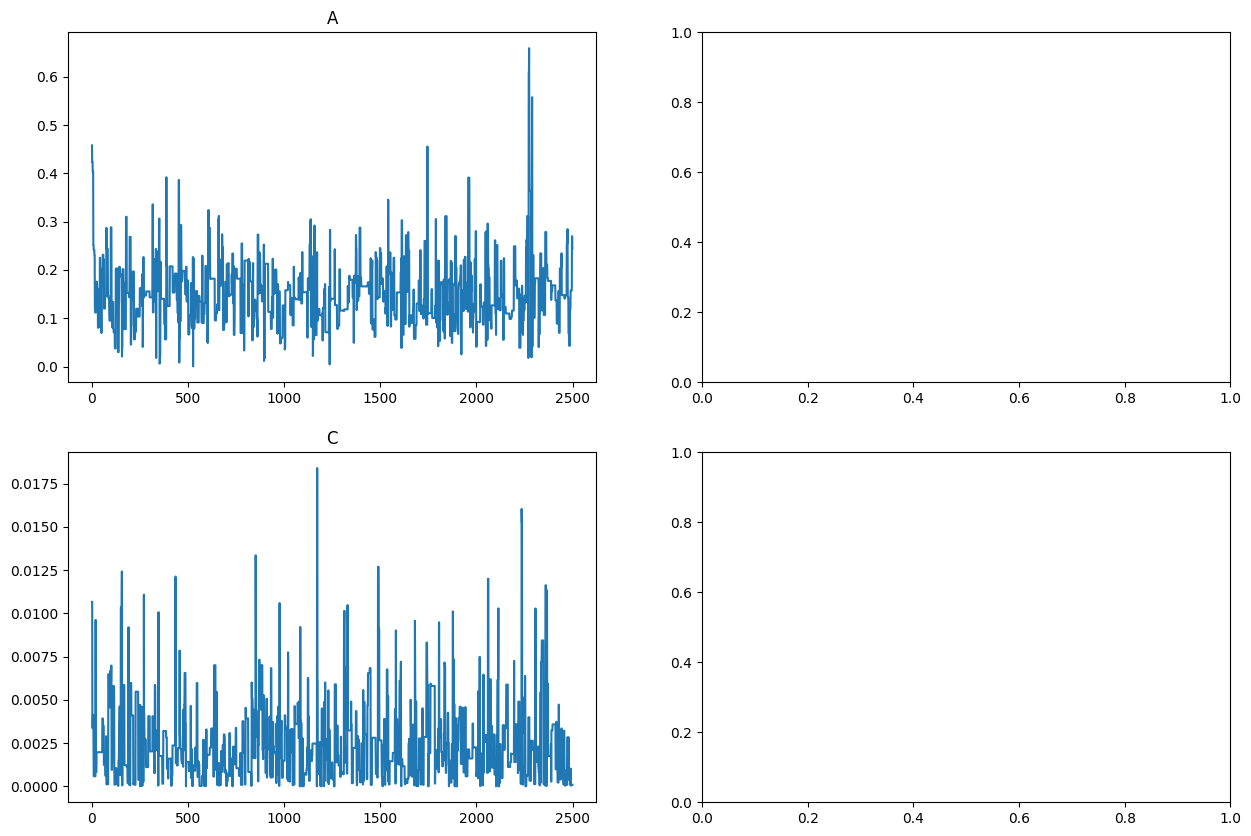

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(((data.params["A"] - pg_samples.thetas["A"])**2)[:, :, 0])
ax[0, 0].set_title("A")
# ax[0, 1].plot(((data.params["Q"] - pg_samples.thetas["Q"])**2)[:, :, 0])
# ax[0, 1].set_title("Q")
ax[1, 0].plot(((data.params["C"] - pg_samples.thetas["C"])**2)[:, :, 0])
ax[1, 0].set_title("C")
# ax[1, 1].plot(((data.params["R"] - pg_samples.thetas["R"])**2)[:, :, 0])
# ax[1, 1].set_title("R")
plt.show()

In [44]:
def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_smoother(params, y)
    print("Exact filter means shape: ", lgssm_posterior.smoothed_means.shape)
    return lgssm_posterior


def bpf(key, data, N: int, params: dict):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(params)
    
    # construct bootstrap particle filter
    bpf = BootstrapParticleFilter(
        model=lgssm,
        config=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key,
        T=data.train_data[0].shape[1],
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs


In [45]:
burn_in = 250
expected_params = {key: value[burn_in:].mean(axis=0) for key, value in pg_samples.thetas.items()}

# extend with non-learnt params
for key, value in data.params.items():
    if key not in expected_params:
        expected_params[key] = value

expected_params

{'A': Array([[0.35121107]], dtype=float32),
 'C': Array([[0.37714735]], dtype=float32),
 'm1': Array([0.], dtype=float32),
 'Q1': Array([[1.]], dtype=float32),
 'b': Array([0.], dtype=float32),
 'Q': Array([[0.46353966]], dtype=float32),
 'R': Array([[0.31622776]], dtype=float32),
 'd': Array([-0.6027049], dtype=float32)}

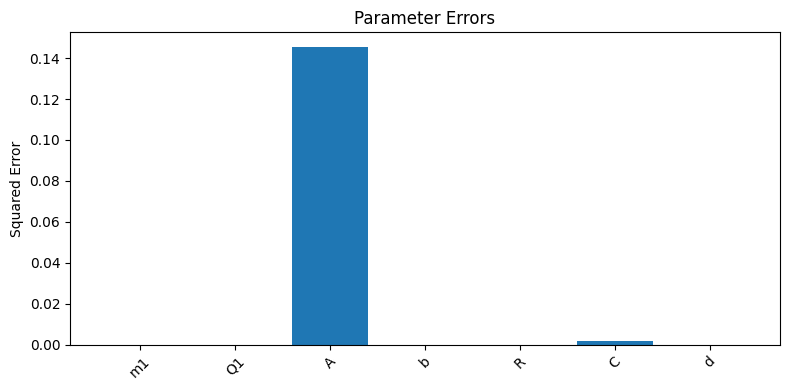

In [46]:
errors = {}
for key in data.params.keys():
    if key != "Q":
        errors[key] = jnp.square(data.params[key] - expected_params[key])

# Convert dict to lists for plotting
keys = list(errors.keys())
values = [float(jnp.mean(v)) for v in errors.values()]  # e.g. mean if each param is a vector/matrix

plt.figure(figsize=(8, 4))
plt.bar(keys, values)
plt.ylabel("Squared Error")
plt.title("Parameter Errors")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
lgssm_posterior = exact_filter(data)
outs = bpf(jr.PRNGKey(10), data, 10, expected_params)
outs.particles.shape, outs.weights.shape

Exact filter means shape:  (300, 1)
BPF particles shape:  (300, 10, 1)
BPF weights shape:  (300, 10)
BPF logZ_hat:  -1175.3661


((300, 10, 1), (300, 10))

N: 5000                                                                                                
BPF particles shape:  (300, 5000, 1)
BPF weights shape:  (300, 5000)
BPF logZ_hat:  -846.9655
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.28784144


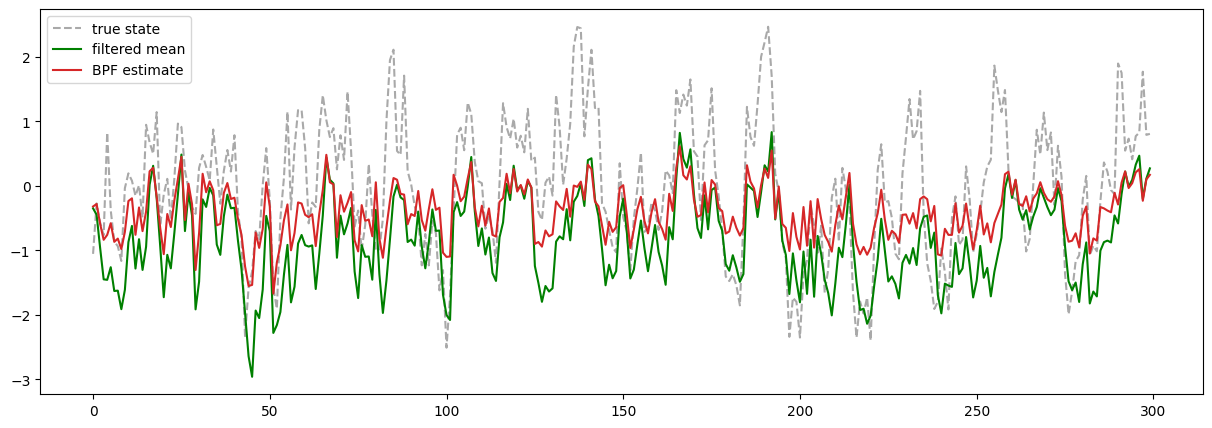

In [48]:
for N in [5000]:
    print(f"N: {N:<-100}")
    outs = bpf(jr.PRNGKey(N), data, N, expected_params)
    
    # calculate weighted estimates of state means
    x_hat = jnp.sum(outs.weights[:, :, None] * outs.particles, axis=1)
    print("BPF weighted x_t shape: ", x_hat.shape)
    
    # calculate MSE against true filter means
    mse = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
    print("MSE from BPF to exact filter means: ", mse)
    
    # plot results
    observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
    ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
    # ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
    ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
    ax.plot(x_hat[:, 3], color="tab:red", label="BPF estimate")
    plt.legend()
    plt.show()
    print("\n\n")